# Module 2 Summative Lab

## Introduction

For today's section, we're going to work on a single big lab to apply everything we've learned in Mod 2!

## About This Lab

A quick note before getting started--this lab isn't like other labs you seen so far. This lab is meant to take ~8 hours to complete, so it's much longer and more challenging than the average labs you've seen so far. If you feel like this lab is challenging or that you might be struggling a bit, don't fret--that's by design! With everything we've learned about Web Scraping, APIs, and Databases, the best way to test our knowledge of it is to build something substantial! 

## The Project

In this lab, we're going to make use of everything we've learned about APIs, databases, and Object-Oriented Programming to **_Extract, Transform, and Load_** (or **_ETL_**, for short) some data from a SQL database into a MongoDB Database. 

You'll find a database containing information about soccer teams and the matches they've played in the file `database.sqlite`. For this project, our goal is to get the data we think is important from this SQL database, do some calculations and data transformation, and then store everything in a MongoDB database. 

Let's get into the specifics of this project.

### The Goal

Start by examining the data dictionary for the SQL database we'll be working with, which comes from this [kaggle page](https://www.kaggle.com/laudanum/footballdelphi).  Familiarize yourself with the tables it contains, and what each column means. We'll be using this database to get data on each soccer team, calculate some summary statistics, and then store each in a MongoDB database. 

Upon completion of this lab, each unique team in this dataset should have a record in the MongoDB instance containing the following information:

* The name of the team
* The total number of goals scored by the team during the 2011 season
* The total number of wins the team earned during the 2011 season
* A histogram visualization of the team's wins and losses for the 2011 season (store the visualization directly by assigning it to a variable)
* The team's win percentage on days where it was raining during games in the 2011 season. 

#### Getting the Weather Data

Note that for this last calculation, you'll need to figure out if it was raining or not during the game. The database itself does not contain this information, but it does contain the date on which the game was played. For this, you'll need to use the [DarkSky API](https://darksky.net/dev) to get the historical weather data for that day. Note that each game is played in a different location, and this information is not contained in our SQL database. However, the teams in this database are largely german, so go ahead and just use the weather in Berlin, Germany as a proxy for this information. If it was raining in Berlin on the day the game was played, count that as rain game--**_you do not need to try and figure out the actual weather at each game's location, because we don't have that information!_**

#### NOTE: The DarkSky API is limited to 1000 free API calls a day, so be sure to test your model on very small samples. Otherwise, you'll hit the rate limit!

## Project Architecture

Unlike previous labs, this lab is more open-ended, and will require you to make design decisions and plan out your strategy for building a system with this many working parts. However, **_using Object-Oriented Programming is a requirement for this project--you must create at least 2 separate, well-structured classes in your solution!_** Although it may seem easier to "just start coding", this is a classic beginner's mistake. Instead, think about separating out the different functionalities you'll need to reach your goal, and then build classes to handle each. For instance, at a minimum, you'll need to:

* Query the SQL database
* Calculate summary statistics
* Get the weather data from the DarkSky API
* Load the data into MongoDB

We **_strongly recommend_** you consider creating separate classes for handling at least some of these tasks.  Be sure to plan the inputs, outputs, and methods for each class before you begin coding! 

**_NOTE:_** We have provided some empty classes below. You are welcome to delete them and use a different architecture for this project if you so choose.  You do not have to use each of them, they are just there to give you an idea of what sorts of classes you may want to consider using.

### Rapid Prototyping and Refactoring

It's totally okay to try to get a task working without using OOP. For instance, when experimenting with the DarkSky API for getting historical weather data, it makes sense to just write the code in the cells and rapidly iterate until you get it all working. However, once you get it working, you're not done--you should then **_Refactor_** your code into functions or classes to make your code more modular, reusable, understandable, and maintainable! 

In short--do what you need to do to get each separate piece of functionality working, and then refactor it into a class after you've figured it out!

### Some Final Advice

You haven't built anything this big or complex thus far, so you may not yet fully realize how much trial and error goes into it. If your code keeps breaking, resist the urge to get frustrated, and just keep working. Software development is an iterative process!  No one writes perfect code that works the first time for something this involved. You're going to run into _a lot_ of small errors in this project, right up until the point where it just works, and then you're done! However, you can reduce these errors by planning out your code, and thinking about how all of the pieces fit together before you begin coding. Once you have some basic understanding of how it all will work, then you'll know what you need to build, and then all that is left is to build it!

In short:

* Plan ahead--you'll thank yourself later!
* Errors and broken code aren't bad, they're normal. 
* Keep working, and stay confident--you can do this!

Good luck--we look forward to seeing your completed project!

In [26]:
# Importing necessary packages:
import base64
import cv2
from PIL import Image
import io
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import pymongo
import requests
import sqlite3

The first thing I am going to do is take a look at the Unique_Teams table in the database.sqlite, since the final MongoDB database will be based off of this list of teams.

In [3]:
conn = sqlite3.connect('database.sqlite')
c = conn.cursor()

In [4]:
c.execute("""SELECT * FROM Unique_Teams;""")
df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
print(len(df))
df.head()

128


,TeamName,Unique_Team_ID
0,Bayern Munich,1
1,Dortmund,2
2,Leverkusen,3
3,RB Leipzig,4
4,Schalke 04,5


I can see that there are 128 unique teams in the dataset, each with an ID.
 - I want to see what the date info looks like in the Matches table

In [5]:
c.execute("""SELECT * FROM Matches;""")
df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
print(len(df))
print(type(df['Date'].iloc[0]))
df.head()

24625
<class 'str'>


,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1,D2,2009,2010-04-04,Oberhausen,Kaiserslautern,2,1,H
1,2,D2,2009,2009-11-01,Munich 1860,Kaiserslautern,0,1,A
2,3,D2,2009,2009-10-04,Frankfurt FSV,Kaiserslautern,1,1,D
3,4,D2,2009,2010-02-21,Frankfurt FSV,Karlsruhe,2,1,H
4,5,D2,2009,2009-12-06,Ahlen,Karlsruhe,1,3,A


I can see that the date is in YYYY-MM-DD format, stored in string format. Looking at the DarkSky API documentation, it appears that this format is appropriate to be plugged directly into the request string. Let's look at how many games were played in the 2011 Season.

In [6]:
# We can see here that while there are 24625 games in the database, there are only 992 games
# that happened in 2011, which are the only ones needed for this lab.
print(len(df[df['Season'] == 2011]))

992


Before I move on, I will take a moment to consider the best way to break down the task at hand:
 - I envision iterating through a list of teams, iterating through a list of games played for each team. A running tally of goals scored and win status can be accumulated through this process, determining the weather for each game based on date.
 - The Teams table will not be needed for this lab.
 - The Teams_in_Matches table will be used to match each team with the matches they have played.
 - Only games played in 2011 need to be considered, so creating a list of unique Match_IDs of games that were in that year, then using the IDs in that list to limit the number of games returned for each Unique_Team_ID from the Teams_in_Matches table would be a good idea to make things move faster.
 - An important consideration is not making more than 1000 API calls in one day. There are 992 games, and 2 teams in each game, so checking the weather on each iteration will be too many. I could build a dataframe for Season 2011 games, with their weather, but that will still be 992 calls. I think I can do better by only making calls for unique dates among the games, then redistributing the rain data to all games based on date.

In [7]:
#Checking number of unique dates in 2011 games:
df[df['Season'] == 2011]['Date'].nunique()

165

Perfect, there are only 165 unique dates played. So the plan then is to make a dictionary of all the dates with their weather, to be used later in establishing weather for each game.

### First, I will build classes with helper functions to interact with the DarkSky API, the sqlite database, and the mongo database:
 - This will let me write the main function in clean python

In [50]:
# This class will contain all relevant code to getting weather from DarkSky API
class WeatherGetter:
    
    def __init__(self):
        self.api_key = self.get_key()
    
    def get_key(self):
        path = "/Users/indez/.secret/darkSky_api.json"
        try:    
            with open(path) as f:
                keys =  json.load(f)
        except:
            print("Error: Failed to load api key")
            return None
        return keys['api_key']
    
    #Function to return the rain status for any given day. Defaults to Berlin, though flexible
    def is_raining(self, date, long = 13.4050, lat = 52.5200):
        # We will use 3pm as the relevant time:
        time = '{}T15:00:00'.format(date)
        response = requests.get(f'https://api.darksky.net/forecast/{self.api_key}/{lat},{long},{time}?exclude=hourly')
        weather = None
        
        # Prioritize 'currently' precipitation info, but resort to 'daily' if missing
        if 'precipIntensity' in response.json()['currently'].keys():
            if response.json()['currently']['precipIntensity'] == 0:
                weather = False
            else:
                weather = True
        else:
            if response.json()['daily']['data'][0]['precipIntensity'] == 0:
                weather = False
            else:
                weather = True
        return weather
    
# This class contains any necessary interaction methods with the database
class SQLHandler:
    
    #Establish connection and cursor
    def __init__(self):
        self.conn = sqlite3.connect('database.sqlite')
        self.c = self.conn.cursor()
        
    # Returns a dataframe of all teams and their respective IDs
    def get_teams(self):
        self.c.execute("""SELECT * FROM Unique_Teams;""")
        teams_df = pd.DataFrame(self.c.fetchall())
        teams_df.columns = [x[0] for x in self.c.description]
        return teams_df
    
    # Returns a dataframe with all games played by a given team, default 2011
    def get_team_season(self, team_id, year = 2011):
        self.c.execute("""SELECT * FROM Matches WHERE Season = {}
                                                AND Match_ID IN (SELECT Match_ID
                                                                        FROM Teams_in_Matches
                                                                        WHERE Unique_Team_ID = {});""".format(year, team_id))
        team_season_df = pd.DataFrame(self.c.fetchall())
        if len(team_season_df) > 0:
            team_season_df.columns = [x[0] for x in self.c.description]
        return team_season_df
    
    # Returns a database with all matches in a given season, default 2011
    def get_season(self, year = 2011):
        self.c.execute("""SELECT * FROM Matches WHERE Season = {};""".format(year))
        season_df = pd.DataFrame(self.c.fetchall())
        season_df.columns = [x[0] for x in self.c.description]
        return season_df
    
class MongoHandler:
    
    def __init__(self, season = 2011):
        self.client = pymongo.MongoClient("mongodb://127.0.0.1:27017/")
        self.db = self.client['soccer_stats_db']
        self.collection = self.db['{}_team_stats'.format(season)]
        
    def add_record(self, record):
        self.collection.insert_one(record)
        
    def clear_all(self):
        self.collection.delete_many({})
        print("All entries cleared!")

In [9]:
# Creat instance and test
SQL = SQLHandler()
test_df = SQL.get_team_season(1)
print(len(test_df))
test_df.head()

34


,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D


In [10]:
plt.style.use('dark_background')

In [95]:
# Function which builds weather reference dictionary for a given year (default 2011)
def build_rain_dict(year = 2011):
    sql = SQLHandler()
    getter = WeatherGetter()
    rain_dict = {}
    season_df = sql.get_season(year)
    unique_dates = season_df['Date'].unique()
    for date in unique_dates:
        rain_dict[date] = getter.is_raining(date)
    return rain_dict

# Enocdes pyplot figure in base64 for storage
def encode_figure(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    return base64.b64encode(buf.read())
    
    
# Primary Function: builds the mongo database for a given season (default 2011)    
def build_season_database(year = 2011, rain_dict = None):
    
    # Initialize helper classes and teams list:
    sql = SQLHandler()
    getter = WeatherGetter()
    mongo = MongoHandler(year)
    team_names = sql.get_teams()
    teams_no_games = 0
    
    # Build date/weather reference dictionary if one is not provided:
    if not rain_dict:
        print('No Rain Dictionary provided, making now...')
        rain_dict = build_rain_dict(year)
        
    # Iterate through each team:
    for idx, row in team_names.iterrows():
        # Set variables:
        print(f"Adding team {row['Unique_Team_ID']}: {row['TeamName']}")
        team_name = row['TeamName']
        goals = 0
        wins = 0
        losses = 0
        draws = 0
        rainy_games = 0
        rainy_wins = 0
        rainy_win_pct = 0
        token = None
        
        # Use SQLHandler to get all 2011 season games for team in pandas df
        team_season_df = sql.get_team_season(row['Unique_Team_ID'], year)
        
        # Iterate through each game in the season, and compile team stats, except if zero games played
        if len(team_season_df) == 0:
            teams_no_games += 1
            print("Team played zero games, now {} teams with no games".format(teams_no_games))
        else:
            for i, game in team_season_df.iterrows():

                # Set weather flag for game
                rainy = rain_dict[game['Date']]
                if rainy:
                    rainy_games += 1

                # Add goals to season total:
                if game['HomeTeam'] == team_name:
                    goals += game['FTHG']
                    token = 'H'
                elif game['AwayTeam'] == team_name:
                    goals += game['FTAG']
                    token = 'A'

                # Check win status and tally correct variable(s):
                if token == game['FTR']:
                    wins += 1
                    if rainy:
                        rainy_wins += 1
                elif game['FTR'] == 'D':
                    draws += 1
                else:
                    losses += 1
            rainy_win_pct = rainy_wins/rainy_games * 100

        # Create plot for win/loss record:        
        x = ['Wins', 'Draws', 'Losses']
        y = pd.Series([wins, draws, losses])
        fig = plt.figure(figsize = (12,8))
        ax = y.plot(kind='bar')
        ax.set_title('{} 2011 Record'.format(team_name), fontsize = 14)
        ax.set_xticklabels(x, rotation='horizontal', fontsize = 14)
        for i, v in enumerate(y):
            ax.text(i - .03, v + .25, str(v), fontsize = 15)
        
        # Build dictionary from variables and add record to mongo database:
        new_record = {"team_name": team_name,
                      "season": year,
                      "total_goals": goals,
                      "season_wins": wins,
                      "season_losses": losses,
                      "season_draws": draws,
                      "rainy_games": rainy_games,
                      "rain_win_percent": rainy_win_pct,
                      "win_record_chart": encode_figure(fig)
                     }
        mongo.add_record(new_record)
        plt.close()
        
        #For debugging purposes:
        #if idx >= 1:
        #    return new_record
        #    break
    print("MongoDB Database made for {} Season".format(year))
    print(f"Reference collection '{year}_team_stats' collection in 'soccer_stats_db' database")

The part of the main function which builds the rain dictionary was isolated so it could be done independently and assigned to a global variable to avoid repetitive API calls when testing code. Below I will build the dictionary first then pass it to the main function, since if the code has bugs the API calls will not be repeated.

In [15]:
rain_dict = build_rain_dict(2011)
pprint.pprint(rain_dict)

{'2011-07-15': False,
 '2011-07-16': False,
 '2011-07-17': False,
 '2011-07-18': False,
 '2011-07-22': True,
 '2011-07-23': False,
 '2011-07-24': False,
 '2011-07-25': False,
 '2011-08-05': False,
 '2011-08-06': False,
 '2011-08-07': False,
 '2011-08-08': True,
 '2011-08-12': False,
 '2011-08-13': False,
 '2011-08-14': False,
 '2011-08-15': False,
 '2011-08-19': False,
 '2011-08-20': False,
 '2011-08-21': False,
 '2011-08-22': False,
 '2011-08-26': False,
 '2011-08-27': False,
 '2011-08-28': False,
 '2011-08-29': False,
 '2011-09-09': False,
 '2011-09-10': False,
 '2011-09-11': False,
 '2011-09-12': False,
 '2011-09-16': False,
 '2011-09-17': False,
 '2011-09-18': False,
 '2011-09-19': False,
 '2011-09-23': False,
 '2011-09-24': False,
 '2011-09-25': False,
 '2011-09-26': False,
 '2011-09-30': False,
 '2011-10-01': False,
 '2011-10-02': False,
 '2011-10-03': False,
 '2011-10-14': False,
 '2011-10-15': False,
 '2011-10-16': False,
 '2011-10-17': False,
 '2011-10-21': False,
 '2011-10-22

In [96]:
build_season_database(2011, rain_dict)

Adding team 1: Bayern Munich
Adding team 2: Dortmund
Adding team 3: Leverkusen
Adding team 4: RB Leipzig
Team played zero games, now 1 teams with no games
Adding team 5: Schalke 04
Adding team 6: M'gladbach
Adding team 7: Wolfsburg
Adding team 8: FC Koln
Adding team 9: Hoffenheim
Adding team 10: Hertha
Adding team 11: Mainz
Adding team 12: Hamburg
Adding team 13: Werder Bremen
Adding team 14: Ein Frankfurt
Adding team 15: Augsburg
Adding team 16: Freiburg
Adding team 17: Stuttgart
Adding team 18: Hannover
Adding team 19: Ingolstadt
Adding team 20: Darmstadt
Team played zero games, now 2 teams with no games
Adding team 21: Paderborn
Adding team 22: Nurnberg
Adding team 23: Braunschweig
Adding team 24: Greuther Furth
Adding team 25: Fortuna Dusseldorf
Adding team 26: Kaiserslautern
Adding team 27: St Pauli
Adding team 28: Bochum
Adding team 29: Karlsruhe
Adding team 30: Bielefeld
Team played zero games, now 3 teams with no games
Adding team 31: Cottbus
Adding team 32: Duisburg
Adding tea

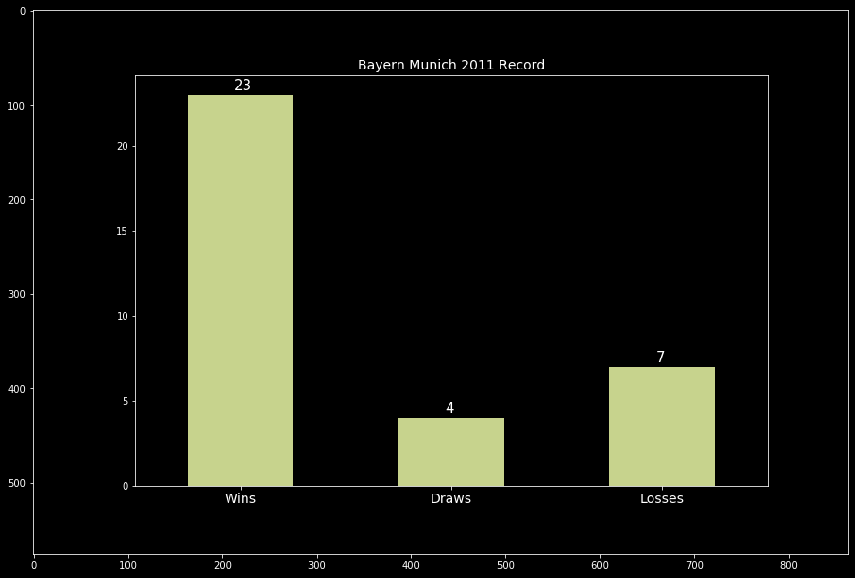

In [98]:
#Code to ensure that the first entry was saved properly:
handler = MongoHandler()

imgdata = base64.b64decode(handler.collection.find({})[0]['win_record_chart'])
image = Image.open(io.BytesIO(imgdata))
pic = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,10))
plt.imshow(pic)
plt.show()

In [93]:
# Run this cell to clear database
handler = MongoHandler()
handler.clear_all()

All entries cleared!


In [97]:
# Run this cell to check number of documents in database
print(len(list(handler.collection.find({}))))

128


The following cell shows the reason why I decided to go with the 'currently' data of 3pm the day of the game for rain status rather than the 'daily' data given for the date of the game. The 'daily' information is given for 10pm the day before the requested date (date of the game), so I figured that weather data coming closer to when the game would have been played would be better.

In [65]:
# Requested time was 3pm on 2011-05-08, daily data gave weather for 10pm the night before
# concerning that day.
from datetime import datetime as dt
print(dt.utcfromtimestamp(1304805600).strftime('%Y-%m-%d %H:%M:%S'))

2011-05-07 22:00:00


# Summary

In this lab, we dug deep and used everything we've learned so far about python programming, databases, HTTP requests and API calls to ETL data from a SQL database into a MongoDB instance!